In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
from jax import numpy as jnp
from jax.experimental import host_callback

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt
from pprint import pprint

from flax import linen as nn
from typing import Sequence

from functools import partial
from typing import Callable, Sequence
from flax import struct
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial
import numpy as np

import actions
import qlearning
import replay
import plotting
from utils import ConvNet, Transition
from frozen_lake import EnvState, FrozenLake, ObsType, ActType, RNGKey

from mango_utils import MultiDQLTrainState
from mango_utils import eps_greedy_rollout, aggregate
import sim

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
seed = 42
map_size = 4
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = 1e-3
max_interactions = 64 * 1000
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

# setup annealing schedules
annealing_durations = [int(train_iter * n_rollouts * p) for p in [0.46, 0.36]]
annealing_starts = jnp.cumsum(jnp.array([0] + annealing_durations[:-1]))
annealing_schedules = [
    optax.linear_schedule(1.0, 0.0, dur, start)
    for dur, start in zip(annealing_durations, annealing_starts)
]


@jax.jit
def annealing_fn(step):
    return jnp.array([schedule(step) for schedule in annealing_schedules])

In [4]:
run_simulation = partial(
    sim.run_mango_simulation,
    map_size=map_size,
    n_rollouts=n_rollouts,
    rollout_length=rollout_length,
    train_iter=train_iter,
    lr=lr,
    annealing_fn=annealing_fn,
)
rng_key = jax.random.PRNGKey(seed)
env, dql_state, results = jax.vmap(run_simulation)(jax.random.split(rng_key, 8))

  0%|          | 0/2000 [00:00<?, ?it/s]

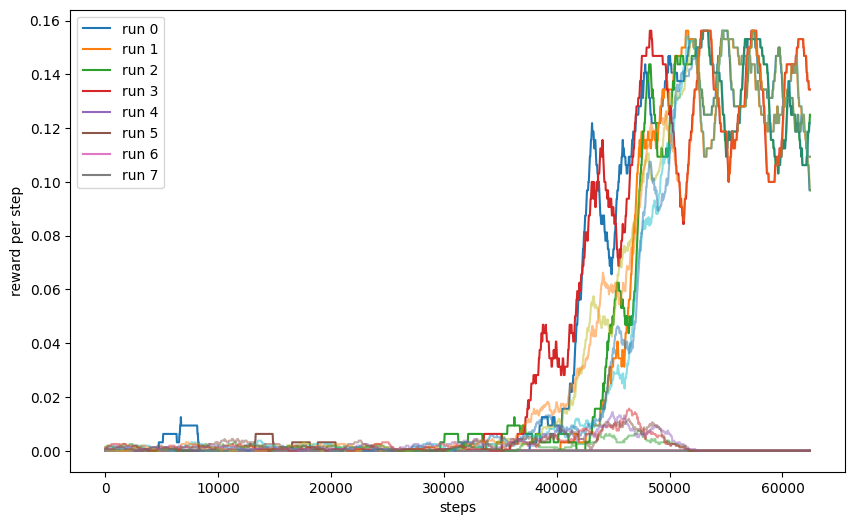

In [5]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")

outer_eval_rewards = results.eval_reward[:,:,:,0,-1]
outer_expl_rewards = results.expl_reward[:,:,:,0,-1]
plt.figure(figsize=(10, 6))
for i, (r, n) in enumerate(zip(outer_eval_rewards.sum(axis=-1), results.eval_done.sum(axis=-1))):
    r = smooth(r) / outer_eval_rewards.shape[-1]
    plt.plot(outer_eval_rewards.shape[-1]*jnp.arange(1,1+len(r)), r, label=f"run {i}")
for i, (r, n) in enumerate(zip(outer_expl_rewards.sum(axis=-1), results.expl_done.sum(axis=-1))):
    r = smooth(r) / outer_expl_rewards.shape[-1]
    plt.plot(outer_expl_rewards.shape[-1]*jnp.arange(1,1+len(r)), r, alpha=0.5)
plt.ylabel("reward per step")
plt.xlabel(f"steps")
plt.legend()

In [8]:
import mango_utils
batch_rollout = jax.vmap(partial(mango_utils.eps_greedy_rollout, rng_key=rng_key, epsilons=jnp.zeros(2), steps=128))
batch_qvals = lambda params, obs: jax.vmap(dql_state.qval_apply_fn, in_axes=(0,None))(params, obs).mean(axis=0)

transitions = batch_rollout(env, dql_state)
outer_eval_rewards = transitions.rewards[:,:,0,-1]
for tot_reward, n_episodes in zip(outer_eval_rewards.sum(axis=-1), transitions.done.sum(axis=-1)):
    print(f"{int(100*tot_reward/n_episodes)}% success" if n_episodes > 0 else "No success")

100% success
100% success
100% success
100% success
No success
No success
No success
No success


In [7]:
results.expl_done.sum()

Array(43163, dtype=int32)